# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle
import cv2
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace eachquestion mark with the appropriate value.

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 0
signnames = {}

import csv
with open("signnames.csv") as f:
    reader = csv.reader(f, delimiter=",")
    next(reader, None) # skip the header
    for row in reader:
        signnames[int(row[0])] = row[1]        

n_classes = len(signnames)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 50000
Number of testing examples = 10000
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import numpy as np

# show an example of each sign
# for name in signnames:
#     index = list(y_train).index(name)
#     image = X_train[index].squeeze()
#     plt.figure(figsize=(1,1))
#     plt.imshow(image, cmap="gray")
#     print(signnames[y_train[index]])


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
# preprocess data

# convert to grayscale
def to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray[..., None]

X_train = list(map(to_gray, X_train))
X_test = list(map(to_gray, X_test))

# reserve some of the training set to use for validation
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

1. The training images were first converted to grayscale to help speed up training. Also, in this application it's probably best to ignore color and rely on shape exclusively. This will likely help the network generalize better since color can be unreliable in different lighting conditions etc and might only serve to hinder performance.
2. Then 20% of the training set was reserved for validation. This allows the accuracy of the network to be measured during training as I experiment with different ideas without ever using the test set. Once an acceptable estimated accuracy is achieved using the training/validation sets, then it can be finally applied to the test set to see how it performs with data the network has never seen before. This technique avoids overfitting the test data.


In [7]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def rotate_img(img, degrees): 
    h,w,d = img.shape
    M = cv2.getRotationMatrix2D((w/2,h/2), degrees, 1)
    return cv2.warpAffine(img, M, (h, w))[..., None]

def darken_img(img, amount): 
    return np.where((255 - img) < 100, 255, img + amount)
    
def zoom_img(img, amount): 
    zoomed = cv2.resize(img, None, fx=amount, fy=amount, interpolation = cv2.INTER_CUBIC)

    h,w,d = img.shape
    h2,w2 = zoomed.shape
    
    hpad = int((h2-h)/2)
    wpad = int((w2-w)/2)
    
    cropped = zoomed[hpad:h+hpad, wpad:w+wpad]
    return cropped[..., None]

def generate_augmented_data(X, y):
    images = []
    labels = []
    for (img, name) in zip(X, y):
        images.append(rotate_img(img, -10))
        labels.append(name)
        images.append(rotate_img(img, 10))
        labels.append(name)
        images.append(darken_img(img, 50))
        labels.append(name)
        images.append(darken_img(img, -50))
        labels.append(name)
        images.append(zoom_img(img, 1.1))
        labels.append(name)
        images.append(zoom_img(img, 1.2))
        labels.append(name)
        images.append(zoom_img(img, 1.3))
        labels.append(name)
        
    return (images, labels)

# generate some fake data by augmenting the original images with small rotations
augmented_images, augmented_labels = generate_augmented_data(X_train, y_train)
X_train.extend(augmented_images)
y_train = np.append(y_train, augmented_labels)

# shuffle the training data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

As noted in a previous step, 20% of the training set was reserved for validation to avoid overfitting to the test set.

Additional training images were created by:
* rotating the original training images by -10 and 10 degrees to make the network less sensitive to exact orientations
* increasing and decreasing original training images by 50 to make the network less sensitive to exact lighting conditions

This technique artificially increases the training set by 4x and helped improve accuracy by a couple percentage points (from about 97.3% to 98.9%). 


In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# initialize tensorflow
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

# Define the network (based on LeNet from previous lab)
def Network(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # regularization
#     conv1 = tf.nn.dropout(conv1, keep_prob)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    layer1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(layer1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # TODO: Activation.
    conv2 = tf.nn.sigmoid(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    layer2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flat = tf.contrib.layers.flatten(layer2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    layer3_W = tf.Variable(tf.truncated_normal([5*5*16, 120], mean=mu, stddev=sigma))
    layer3_b = tf.Variable(tf.zeros(120))
    layer3 = tf.add(tf.matmul(flat, layer3_W), layer3_b)
    
    # TODO: Activation.
    layer3 = tf.nn.relu(layer3)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    layer4_W = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    layer4_b = tf.Variable(tf.zeros(84))
    layer4 = tf.add(tf.matmul(layer3, layer4_W), layer4_b)

    # TODO: Activation.
    layer4 = tf.nn.sigmoid(layer4)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    layer5_W = tf.Variable(tf.truncated_normal([84, n_classes], mean=mu, stddev=sigma))
    layer5_b = tf.Variable(tf.zeros(n_classes))
    layer5 = tf.add(tf.matmul(layer4, layer5_W), layer5_b)
    return layer5



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The newtork is basically LeNet with a few minor improvements:
* using sigmoid instead of relu activation improved accuracy from 95.3% to 96.2%
* converting images to grayscale first further improved accuracy to 97.3%
* generating augmented data using rotation improved to 98.3%
* generating augmented data using brightness improved to 98.9%

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

# placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32) # probability to keep units

# training
rate = 0.001

logits = Network(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# model evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The network was trained using the Adam optimizer, with batch size of 128 over 10 epochs. Changing those parameters in any way always reduced accuracy.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with the LeNet architecture of the previous lab. Without any changes it was already 95% accurate. Here are some of the things I tried and their results:
* add dropout after conv1 - didn't help (had to increase epochs to 15 just to get 94%)
* moved dropout to after conv2 - basically same result
* using sigmoid instead of relu activation improved accuracy from 95.3% to 96.2%
* converting images to grayscale first further improved accuracy to 97.3%
* generating augmented data using rotation improved to 98.3%
* generating augmented data using brightness improved to 98.9%
* generating augmented data using zoomed images didn't seem to improve accuracy at all

I was a bit frustrated by the "black magic" of improving deep learning. It is basically a bunch of guesswork and not all that much intuition. The project instructions implied that we should start with LeNet from the previous lab and go from there. The stock LeNet architecture was already pretty darn good at 95% accuracy. I was only able to increase accuracy moderately to 98.9%. 

Probably the biggest surprise, considering how it was hyped up in the lectures, is that dropout gave no improvements at all (slightly hurt accuracy at best).


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Labels: [ 1  2 17 11 12 18]


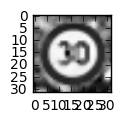

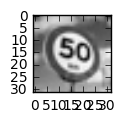

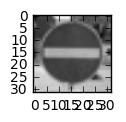

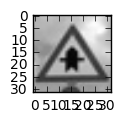

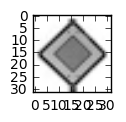

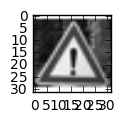

In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os

test_files = { 1: "speed-limit-30.jpg", 2: "speed-limit-50.jpg", 11: "right-of-way.jpg", 12: "priority-road.jpg", 17: "no-entry.jpg", 18: "caution.jpg"}
              
def load_test_image(file):
    image = cv2.imread("test-images/{}".format(file), cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap="gray")
    return image[..., None]
              
X_captured = list(map(load_test_image, test_files.values()))
y_captured = np.array(list(test_files.keys()))

print("Labels: {}".format(y_captured))


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The images I selected were initially all pretty clear and thus easy to classify. I decided to blur and warp a few of them with photoshop, but they were still properly classified.

In [9]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    validation_accuracy = evaluate(X_test, y_test)
    print("Test set Accuracy = {:.3f}".format(validation_accuracy))

    validation_accuracy = evaluate(X_captured, y_captured)
    print("Captured set Accuracy = {:.3f}".format(validation_accuracy))


Test set Accuracy = 0.945
Captured set Accuracy = 1.000


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model had an accuracy of 94.3% on the provided test set. It had perfect accuracy on my captured images from the web even after distorting and blurring some of them.


In [15]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

prediction = tf.nn.softmax(logits)
topFive = tf.nn.top_k(prediction, k=5, sorted=True, name=None)

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    percentages, labels = sess.run(topFive, feed_dict={x: X_captured, y: y_captured})
    print("top 5 percentages: \n{}".format(percentages))
    print()
    print("top 5 labels: \n{}".format(labels))

top 5 percentages: 
[[  9.98011589e-01   9.34191397e-04   5.85336762e-04   2.04685522e-04
    1.30300614e-04]
 [  8.64703417e-01   1.25832677e-01   5.59926359e-03   2.17943010e-03
    1.21064670e-03]
 [  9.99990344e-01   6.01497413e-06   2.18365653e-06   6.52741505e-07
    4.01695473e-07]
 [  9.99953628e-01   2.84095313e-05   6.92310368e-06   6.69183191e-06
    1.79575318e-06]
 [  9.99992847e-01   7.15457327e-06   2.70905378e-08   2.12830429e-08
    1.99937578e-08]
 [  9.97049332e-01   2.52178893e-03   3.40324797e-04   5.97050566e-05
    1.28264210e-05]]

top 5 labels: 
[[ 1  0  4  7  5]
 [ 2  5  3  7  8]
 [17  9 33 34 14]
 [11 30 21 27 28]
 [12 40  7 35  1]
 [18 27 26 24 25]]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The model is very certain about each prediction: 
* Speed limit 30: 99.8%
* Speed limit 50: 86.5%
* No entry: 99.9%
* Right-of-way: 99.9%
* Priority road: 99.9%
* General caution: 99.7%

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.